In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of a feature layer that have users and movies embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
*  **Movie id**: Idem to User id.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

### Required libraries

In [4]:
import sys
sys.path.append('./src')

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from callback import MetricsPlotter
from util import tf_detected_devices, tf_version, plot_model, dataframe_to_dataset, PCAPlotter, random_colors, random_color 
from model import EmbeddingDenseModelFactory, Recommender, ValueIndexMapper, Model
from data import InMemoryXyDataGenerator, MovieLensDataSource, Dataset

### Config parameters

In [5]:
train_model = False

dataset_size = 'ml-latest' # 250MB
# dataset_size = 'ml-25m' # 25MB
# dataset_size = 'ml-latest-small' # 1MB

### Check environment

Show GPU model:

In [6]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce GTX 1060, 6078 MiB


Let's check tensorflow version:

In [7]:
tf_version()

'Tensorflow version: 2.4.0-dev20200924'

Let's check devices that tensorflow detect:

In [8]:
tf_detected_devices()

Name Device Type Memory  \
0  /device:CPU:0         CPU   256M   
1  /device:GPU:0         GPU     4G   

                                         Description  
0                                                     
1  device: 0, name: GeForce GTX 1060, pci bus id:...

In [9]:
tf.debugging.set_log_device_placement(False)

In [10]:
tf.test.is_built_with_cuda()

True

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Download dataset

Create a data source to download and read dataset files:

In [12]:
print('Dataset sizes:', MovieLensDataSource.sizes())

Dataset sizes: ['ml-latest-small', 'ml-25m', 'ml-latest']


Check: [Movie lens datasets](https://grouplens.org/datasets/movielens/)

In [13]:
ds = MovieLensDataSource(size = dataset_size)

In [14]:
dataset = ds.dataset()

Available files:

In [15]:
print(ds.files())

['ratings.csv', 'genome-scores.csv', 'links.csv', 'movies.csv', 'genome-tags.csv', 'tags.csv']


Rating that users give to each movie:

In [16]:
dataset.ratings().head()

userId  movieId  rating   timestamp  user  movie
0       1      307     3.5  1256677221     0    304
1       1      481     3.5  1256677456     0    477
2       1     1091     1.5  1256677471     0   1069
3       1     1257     4.5  1256677460     0   1229
4       1     1449     4.5  1256677264     0   1414

In [17]:
dataset.ratings().isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
user         0
movie        0
dtype: int64

Movie catalog: Each movie has a tittle and a list of genres.

In [18]:
dataset.movies().head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

Tags that users put to movies: Each line of this file after the header row represents one tag applied to one movie by one user.

In [19]:
dataset.tags().head()

userId  movieId           tag   timestamp
0      14      110          epic  1443148538
1      14      110      Medieval  1443148532
2      14      260        sci-fi  1442169410
3      14      260  space action  1442169421
4      14      318  imdb top 250  1442615195

**Links** file contains one row by movie and eack column represent the movie id for each movie site:

* **movieId**: is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

* **imdbId**: is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

* **tmdbId**: is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>

**Note**: It will we usefull when we test each model.

In [20]:
dataset.links().head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

## Analize and prepare the required data

First, get 15 users with highest total ratings sum: 

In [21]:
dataset.highest_user_ratings(limit=15).head()

rating
userId        
123100   23715
117490    9279
134596    8381
212343    7884
242683    7515

Get 15 moviles with highest total ratings sum:

In [22]:
dataset.highest_movie_ratings(limit=15).head()

rating
movieId        
318       97999
356       97040
296       92406
593       87899
2571      84545

Show users vs. movies ratings: It can appresciated that some user did not give a rating to some movies (NaN).

In [23]:
dataset.top_user_vs_movies(limit=15)

movieId  1     110   260   296   318   356   480   527   589   593   1196  \
userId                                                                      
48470     4.5   4.5   4.0   5.0   4.5   4.0   4.0   4.5   5.0   3.5   4.0   
63783     5.0   1.0   5.0   5.0   5.0   4.0   4.0   5.0   4.0   5.0   5.0   
77609     3.0   4.0   3.0   4.0   4.0   4.0   4.0   4.0   4.0   4.5   2.5   
94843     1.0   2.5   2.5   3.5   2.5   3.0   1.0   0.5   NaN   3.0   2.5   
111908    5.0   3.5   5.0   5.0   5.0   2.0   3.0   5.0   4.0   2.0   5.0   
117490    4.0   5.0   4.0   4.5   4.0   4.0   3.0   4.0   4.0   4.0   4.0   
123100    4.0   3.5   4.0   4.5   4.5   3.5   4.0   4.5   4.0   4.0   4.0   
134596    3.0   4.0   4.0   4.0   4.5   3.0   4.0   4.0   4.0   4.0   4.0   
141955    2.5   2.5   3.5   3.0   1.0   1.0   2.0   NaN   3.0   3.0   3.5   
158002    5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
172357    4.0   4.0   3.0   5.0   5.0   2.0   2.5   3.5   5.0   4.0   5.0   
183233    3.0   4.0   3.0   4.0   4.0   3.0   4.0   4.0   4.0   4.0   3.0   
212343    3.5   4.0   0.5   5.0   5.0   3.5   3.0   4.5   3.5   5.0   0.5   
242683    5.0   4.0   5.0   5.0   4.5   4.5   4.0   5.0   5.0   5.0   5.0   
253511    4.0   4.0   4.0   4.5   4.0   3.5   4.0   4.0   4.0   4.5   4.0   

movieId  1198  1210  2571  2959  
userId                           
48470     3.0   3.5   3.5   3.5  
63783     4.0   5.0   5.0   5.0  
77609     4.0   3.0   4.0   2.0  
94843     2.5   1.0   3.0   2.5  
111908    5.0   3.5   5.0   4.0  
117490    4.0   4.0   4.0   3.0  
123100    4.0   4.0   4.0   3.5  
134596    4.5   4.0   4.5   4.0  
141955    3.0   3.0   2.5   1.5  
158002    5.0   4.0   5.0   5.0  
172357    5.0   3.0   4.0   1.0  
183233    4.0   3.0   5.0   4.0  
212343    4.5   1.0   1.5   4.5  
242683    5.0   4.0   5.0   4.0  
253511    4.0   4.0   4.0   4.5

Users and movies count:

In [24]:
n_users, n_movies = dataset.n_users(), dataset.n_movies()
n_users, n_movies

(283228, 53889)

Min and max rating:

In [25]:
min_rating, max_rating = dataset.min_rating(), dataset.max_rating()
min_rating, max_rating

(0.5, 5.0)

Build X and y sets (Equivalent to features and label for ech training test).

In [26]:
X = dataset.ratings()[['user', 'movie']].values
y = dataset.ratings()['rating'].values

Show features an label for first sample:

In [27]:
X[0], y[0]

(array([  0, 304]), 3.5)

Split data to train, validation and test sets:

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01) # , random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((27475909, 2), (27475909,), (277535, 2), (277535,))

### Deep Model: User and Movie embeddings + Dense layers 

Define train and validation batch size: 

In [29]:
import math

if dataset_size == 'ml-latest':
    steps  = 20
    epochs = 25
elif dataset_size == 'ml-25m':
    steps  = 20
    epochs = 20
else:
    steps  = 200
    epochs = 20

batch_size        = math.floor(X_train.shape[0] / steps)
val_batch_size    = math.floor(X_val.shape[0] / steps)
plot_interval     = math.floor(steps / 2)
evaluate_interval = plot_interval + 1

print('Train Batch Size     :', batch_size)
print('Validation Batch Size:', val_batch_size)
print('Plot Interval        :', plot_interval)
print('Evaluate Interval    :', evaluate_interval)

Train Batch Size     : 1373795
Validation Batch Size: 13876
Plot Interval        : 10
Evaluate Interval    : 11


Define data generators. This are used in the model train process(fit) to generate a samples batch.

In [30]:
def to_input(X, y): return [X[:, 0], X[:, 1]], y

training_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train, 
    batch_size, 
    shuffle=True, 
    to_input=to_input
)

validation_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val,
    val_batch_size,
    shuffle=True,
    to_input=to_input
)

Create the model:

In [31]:
model = UserMovieGenderEmbeddingDenseModelFactory.create(
    n_users, 
    n_movies, 
    n_factors=50,
    min_rating=min_rating, 
    max_rating=max_rating,
    units=[100],
    dropout=[0]
)

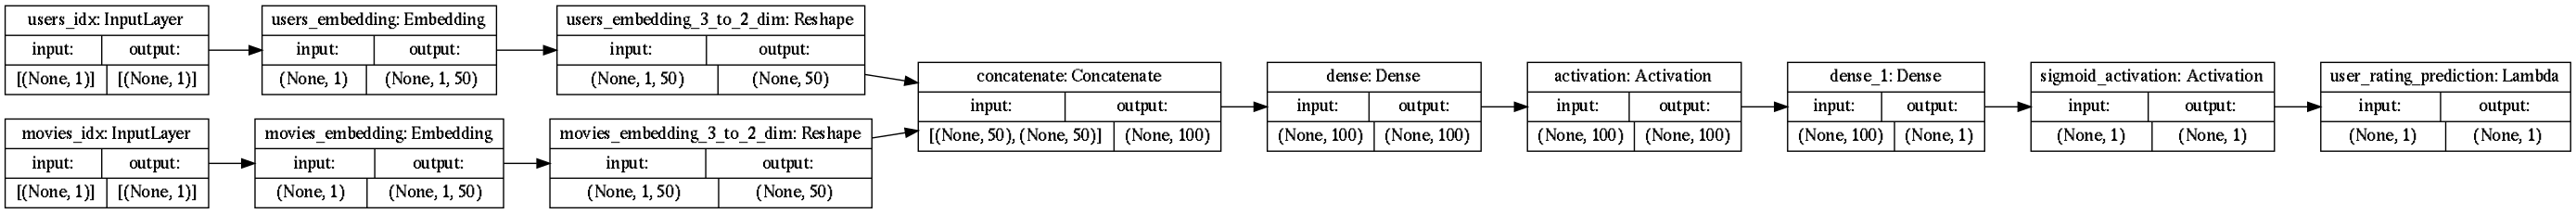

In [32]:
plot_model(model)

In [33]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 50)        14161400    users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 50)        2694450     movies_idx[0][0]                 
____________________________________________________

Train model:

In [34]:
if train_model:
    history = model.fit_generator(
        generator=training_generator,
        validation_data=validation_generator,
        epochs=2,
        verbose=1, 
        callbacks=[
            MetricsPlotter(
                validation_generator=validation_generator, 
                metrics_names=['loss'],
                plot_interval=plot_interval,
                evaluate_interval=evaluate_interval,
                batch_size=batch_size,
                val_batch_size=val_batch_size
            )
        ]
    )

Save the weights tthat model has learned:

In [35]:
WEIGHTS_PATH = f'./weights/deep_model_weights_{dataset_size}.h5'

model.save_weights(WEIGHTS_PATH) if train_model else model.load_weights(WEIGHTS_PATH)

Check model loss after training process:

In [36]:
def evaluate_xy_model(model, X, y, batch_size):
    data_generator = InMemoryXyDataGenerator(X, y, len(y), to_input=to_input)    
    X_t, y_t = data_generator[0]
    return model.evaluate(X_t, y_t, batch_size=batch_size, verbose=0)

In [37]:
evaluate_xy_model(model, X_val, y_val, batch_size)

0.6481702327728271

## Check rating prediction

In [38]:
import random

class UserMovieIdxPairGenerator:
    def __init__(self, train_input, dataset):
        self.__train_input = pd.DataFrame(X, columns=['user', 'movie'])
        self.__dataset = dataset

    def rand_user_idx(self): return random.choice(self.__train_input['user'])
 
    def rand_movie_idx(self): return random.choice(self.__train_input['movie'])
 
    def generate(self, has_rating=True):
        finish = True
        user_idx, movie_idx = None, None
        while finish:
            user_idx, movie_idx = self.rand_user_idx(), self.rand_movie_idx()
            pair = self.__dataset.rating_of(user_idx, movie_idx)
            finish = pair.empty if has_rating else not pair.empty
        return user_idx, movie_idx

In [39]:
pair_generator = UserMovieIdxPairGenerator(X, dataset)

In [40]:
user_idx, movie_idx = pair_generator.generate(has_rating=True)
dataset.rating_of(user_idx, movie_idx)

user  movie  userId  movieId  rating                     title  \
0  43879   4900   43880     4995     4.5  Beautiful Mind, A (2001)   

          genres  
0  Drama|Romance

In [41]:
user_idx, movie_idx = pair_generator.generate(has_rating=False)
dataset.rating_of(user_idx, movie_idx)

Empty DataFrame
Columns: [user, movie, userId, movieId, rating, title, genres]
Index: []

Predict a non-existent rating:

In [42]:
user_idx, movie_idx = pair_generator.generate(has_rating=False)
Model(model).predict_rating(user_idx=104, movie_idx=0)

movie  predicted_rating
0      0          4.163556

In [43]:
 dataset.rating_of(user_idx, movie_idx)

Empty DataFrame
Columns: [user, movie, userId, movieId, rating, title, genres]
Index: []

Predict ratings used to train model:

In [44]:
def rand_compare_train_rating():
    user_idx, movie_idx = pair_generator.generate()
    movie_ratting = dataset.rating_of(user_idx, movie_idx)
    predicted_movie_ratting = Model(model).predict_rating(user_idx, movie_idx)
    result = pd.merge(movie_ratting, predicted_movie_ratting, how='left', on='movie')
    return result[['user', 'movie', 'title', 'predicted_rating', 'rating']]

In [45]:
rand_compare_train_rating()

user  movie           title  predicted_rating  rating
0  155083   3941  Traffic (2000)          4.332853     4.5

In [46]:
rand_compare_train_rating()

user  movie          title  predicted_rating  rating
0  110005    586  Batman (1989)          3.589097     3.0

In [47]:
rand_compare_train_rating()

user  movie             title  predicted_rating  rating
0  247495  11322  Idiocracy (2006)          3.823183     3.5

In [48]:
rand_compare_train_rating()

user  movie                     title  predicted_rating  rating
0  95844   1196  Full Metal Jacket (1987)          3.883365     4.0

In [49]:
rand_compare_train_rating()

user  movie                        title  predicted_rating  rating
0  256515  13683  Inglourious Basterds (2009)          4.062585     3.5

In [50]:
rand_compare_train_rating()

user  movie           title  predicted_rating  rating
0  67271   4133  Memento (2000)          3.620842     3.0

### Check recommendations

In [51]:
recommender = Recommender(model, dataset)

#### Top movies for a user

In [52]:
def rand_compare_top_movies(limit=10):
    user_id = random.choice(dataset.user_ids())
    print(f'User Id: {user_id}\n')
    return recommender.top_movies_by_user_id(user_id, limit=limit)

In [53]:
rand_compare_top_movies()

User Id: 98709



predicted_rating                                      title  movieId  \
12665          4.659956          Sherlock - A Study in Pink (2010)   185135   
1430           4.638637     Avengers: Infinity War - Part I (2018)   122912   
174            4.636790                           Rock, The (1996)      733   
7392           4.628093    Doctor Who: Voyage Of The Damned (2007)   147382   
7393           4.614716       Doctor Who: The Runaway Bride (2007)   147384   
110            4.613173           Shawshank Redemption, The (1994)      318   
7321           4.606737  Doctor Who: The Time of the Doctor (2013)   117192   
2538           4.602818                       The Lost Room (2006)   140737   
7389           4.599679       Doctor Who: A Christmas Carol (2010)   147376   
5262           4.598053                      Hidden Figures (2016)   166643   

       movie  
12665  50473  
1430   26879  
174      721  
7392   35612  
7393   35613  
110      315  
7321   25277  
2538   33073  
7389   35609  
5262   42672

#### Similar movies

In [54]:
def rand_similar_movies(title=None, limit=10):
    print(f'Movie\n')
    
    if title:
        movie = dataset.movies_by_title(title)[:1]
        movie_id = movie['movieId'].item()
        display(movie)
    else:
        movie_id = random.choice(dataset.movie_ids())
        display(dataset.movie_by_id(movie_id))

    print(f'Similars (UNORDERED!!!)')
    return recommender.movies_similar_to(movie_id, limit=limit)

In [55]:
recommended_movies = rand_similar_movies(title='Toy', limit=20)
recommended_movies

Movie



movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy

Similars (UNORDERED!!!)


movieId  movie                                              title  \
0             1      0                                   Toy Story (1995)   
68469       595    589                        Beauty and the Beast (1991)   
110869      914    897                                My Fair Lady (1964)   
122958      953    936                       It's a Wonderful Life (1946)   
140728     1307   1278                     When Harry Met Sally... (1989)   
166748     2396   2312                         Shakespeare in Love (1998)   
194084     3114   3028                                 Toy Story 2 (1999)   
223904     4993   4898  Lord of the Rings: The Fellowship of the Ring,...   
285787     6377   6272                                Finding Nemo (2003)   
322787    27684   9433                           Wondrous Oblivion (2003)   
322801    33917  10210                  Member of the Wedding, The (1952)   
322808    63772  13189                    Bullfighter and the Lady (1951)   
322813    78499  15454                                 Toy Story 3 (2010)   
337654    81903  16259            Lost Skeleton Returns Again, The (2009)   
337664   139150  32454                             Subramaniapuram (2008)   
337673   149642  36364            Steve McQueen: The Man & Le Mans (2015)   
337676   150954  36800                                          Ko (2011)   
337683   152674  37379                         As the Palaces Burn (2014)   
337687   163314  41358                Larry Kramer In Love & Anger (2015)   
337693   169274  43776                        The Fabulous Pastars (2016)   

                                                  genres  
0            Adventure|Animation|Children|Comedy|Fantasy  
68469    Animation|Children|Fantasy|Musical|Romance|IMAX  
110869                      Comedy|Drama|Musical|Romance  
122958                    Children|Drama|Fantasy|Romance  
140728                                    Comedy|Romance  
166748                              Comedy|Drama|Romance  
194084       Adventure|Animation|Children|Comedy|Fantasy  
223904                                 Adventure|Fantasy  
285787               Adventure|Animation|Children|Comedy  
322787                             Children|Comedy|Drama  
322801                                             Drama  
322808                              Action|Drama|Romance  
322813  Adventure|Animation|Children|Comedy|Fantasy|IMAX  
337654                                            Comedy  
337664                       Action|Comedy|Drama|Romance  
337673                                       Documentary  
337676                          Action|Children|Thriller  
337683                               Documentary|Musical  
337687                                       Documentary  
337693                                            Comedy

In [56]:
similar_movie_ids = recommended_movies['movieId'].unique()

In [57]:
import textwrap

simiar_movie_titles = recommended_movies['title'].unique()
r = dataset.ratings().groupby('movieId')['movieId', 'rating'].mean()

similar_movie_ratings = [r[r['movieId'] ==  i]['rating'].item() for i in similar_movie_ids]
simiar_movie_titles = [f'  {r:1.3f} - {textwrap.shorten(t, width=20)}' for t, r in zip(simiar_movie_titles, similar_movie_ratings)]

In [58]:
movie_embeddings = Model(model).movie_embeddings_matrix

movie_title = recommended_movies['title'][:1].item()
similar_movie_labels = {title:[idx] for idx, title in enumerate(simiar_movie_titles)}
similar_movie_indexes = recommended_movies['movie'].unique()
similar_movie_embeddings = np.take(movie_embeddings, axis=0, indices=similar_movie_indexes)

pca = PCA(n_components=2)
similar_movie_pca = pca.fit_transform(similar_movie_embeddings)

In [59]:
comp_var = [f'{cv * 100:.0f}%' for cv in pca.explained_variance_ratio_]
tot_variance = f'{sum(pca.explained_variance_ratio_) * 100:.0f}%'

print(f'Variance by dimnesion: {comp_var}')
print(f'Variance: {tot_variance}')

Variance by dimnesion: ['86%', '4%']
Variance: 91%


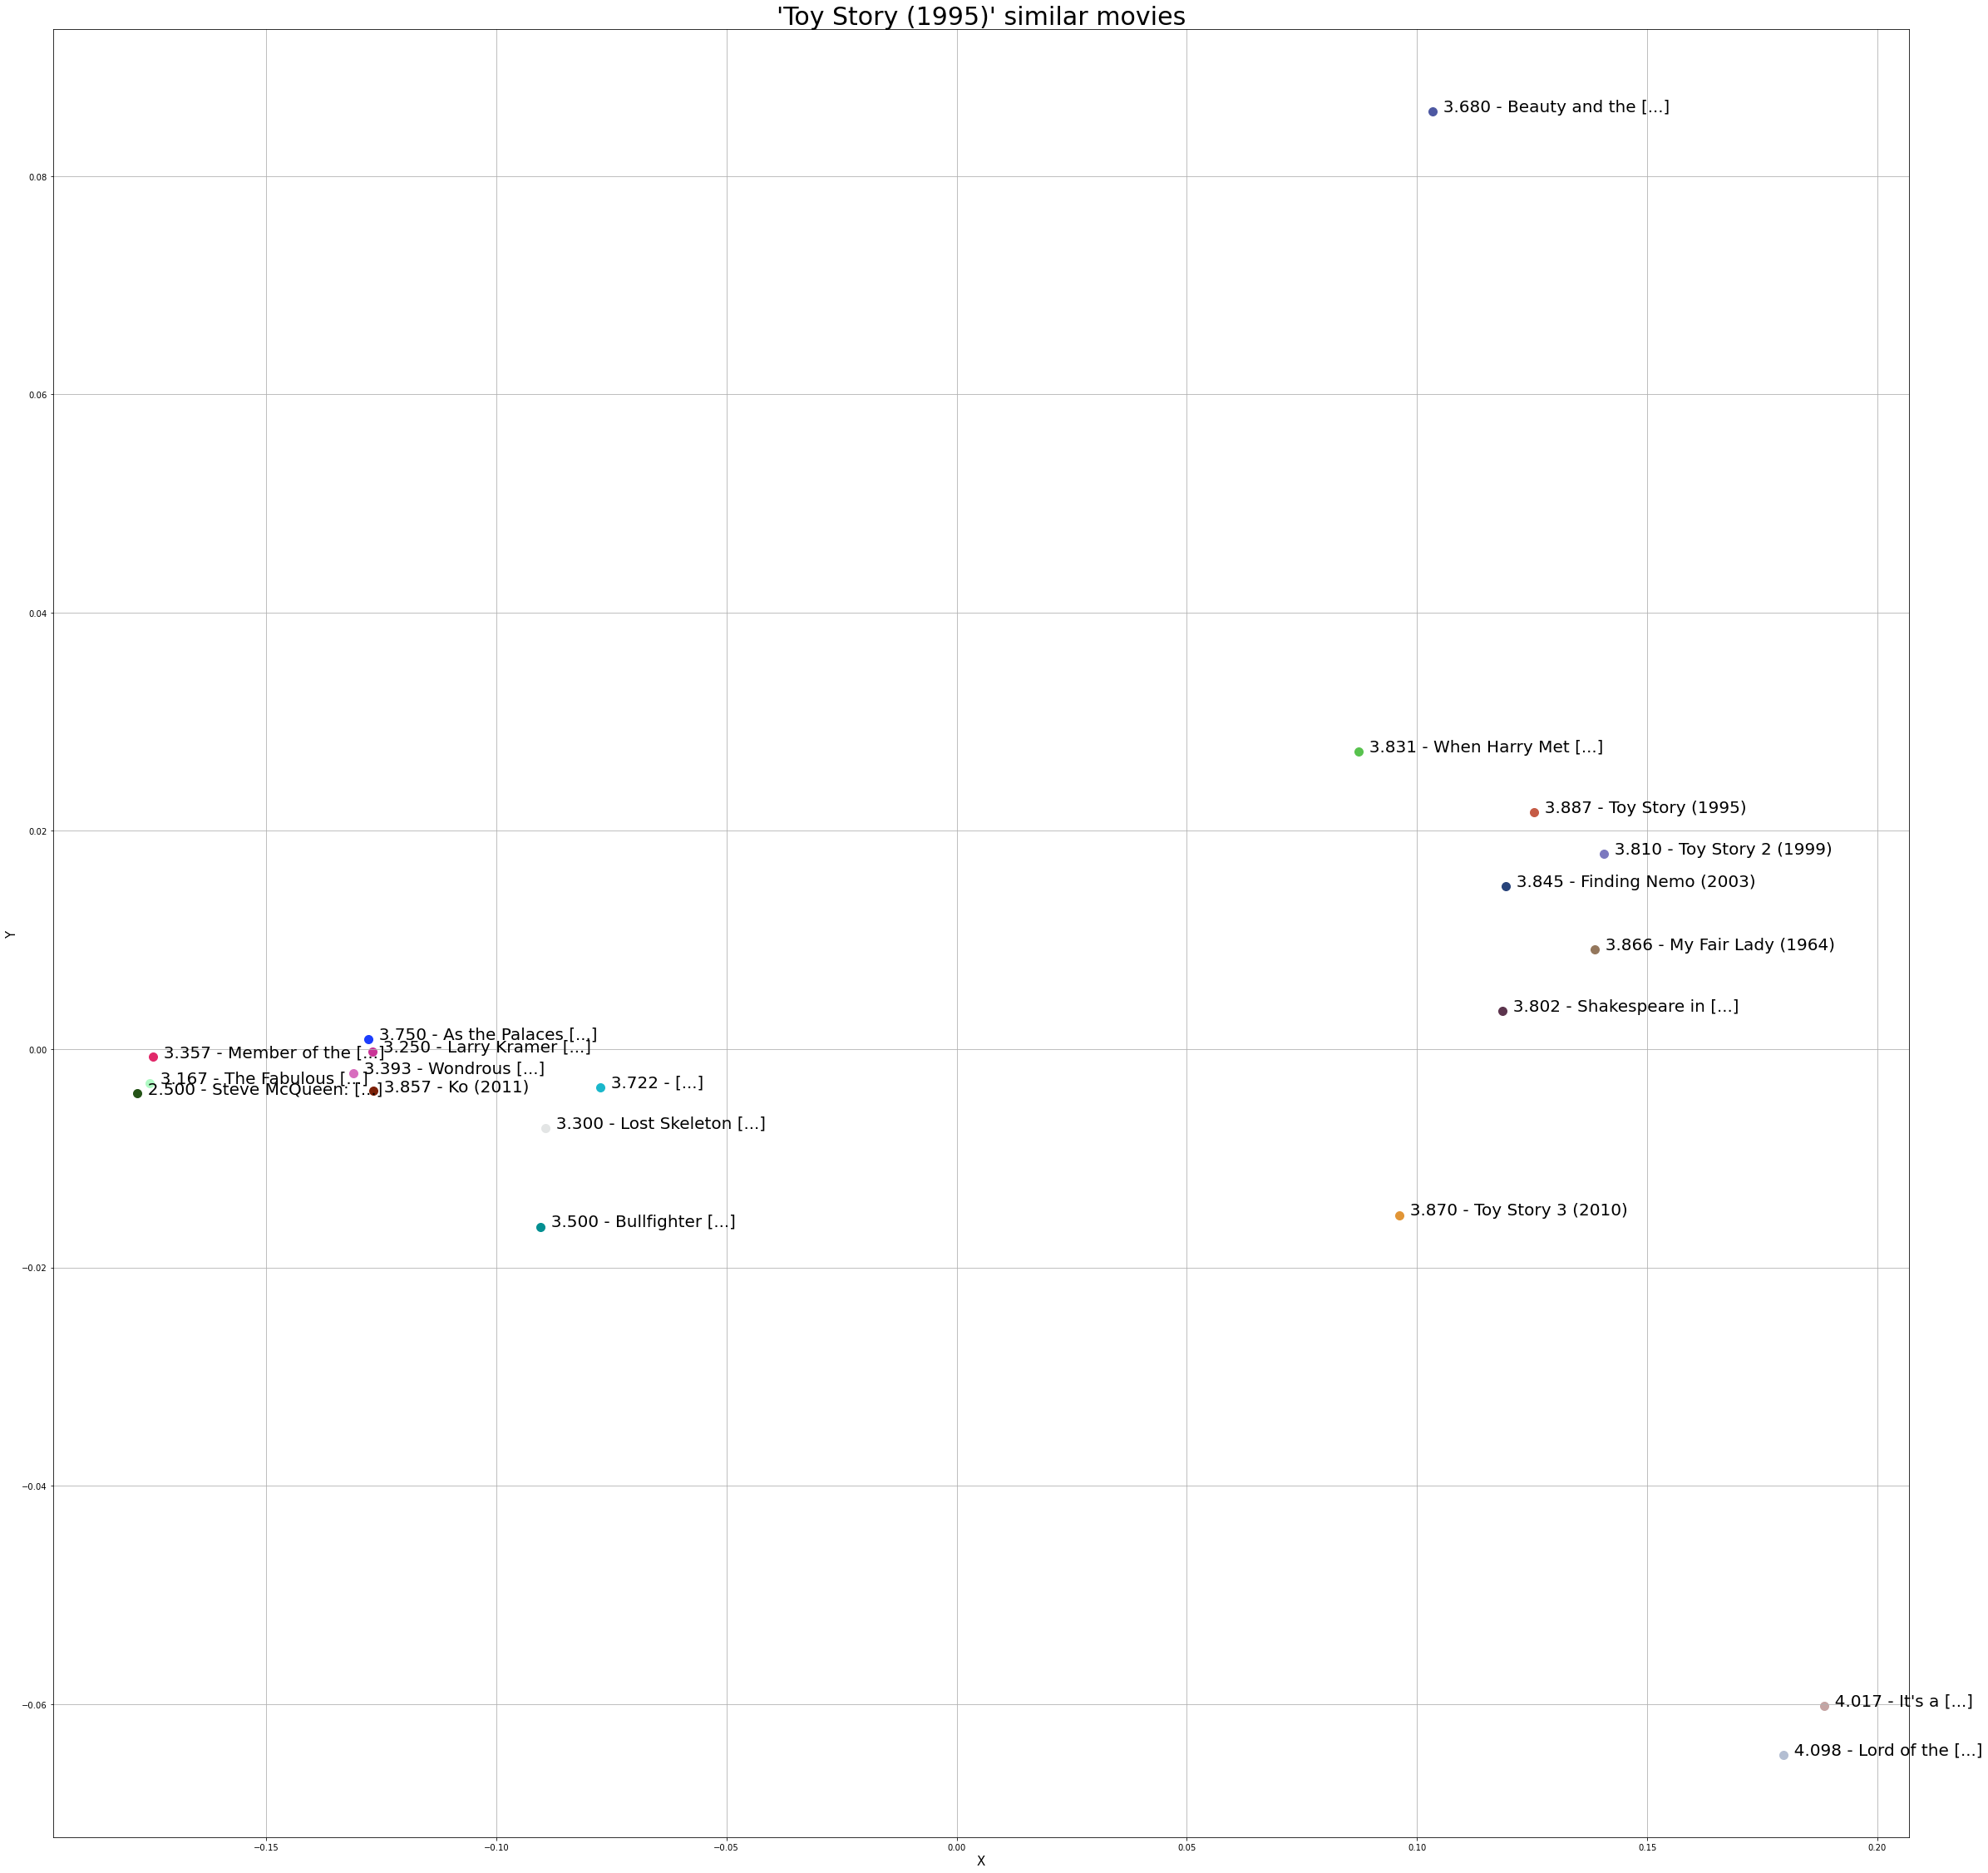

In [60]:
PCAPlotter() \
    .data(similar_movie_pca) \
    .canvas(size=(40, 40)) \
    .labels(similar_movie_labels) \
    .title(f'\'{movie_title}\' similar movies', font_size = 30) \
    .annotations(font_size=20) \
    .point(radius=100, color_distance=.2) \
    .plot()

#### Similar users

In [61]:
def rand_similar_users():
    user_id = random.choice(dataset.user_ids())
    print(f'User Id: {user_id}\n')
    print(f'Similars (Unordered): {recommender.users_similar_to(user_id, limit=10)}')

In [62]:
rand_similar_users()

User Id: 104971

Similars (Unordered): [104971, 10674, 282754, 267261, 272162, 82455, 188740, 65410, 119846, 280503]


### Plot user and movie embedings

In [63]:
movie_embeddings = Model(model).movie_embeddings_matrix
user_embeddings = Model(model).user_embeddings_matrix

movies_pca = PCA(n_components=3).fit_transform(movie_embeddings)
users_pca = PCA(n_components=3).fit_transform(user_embeddings)

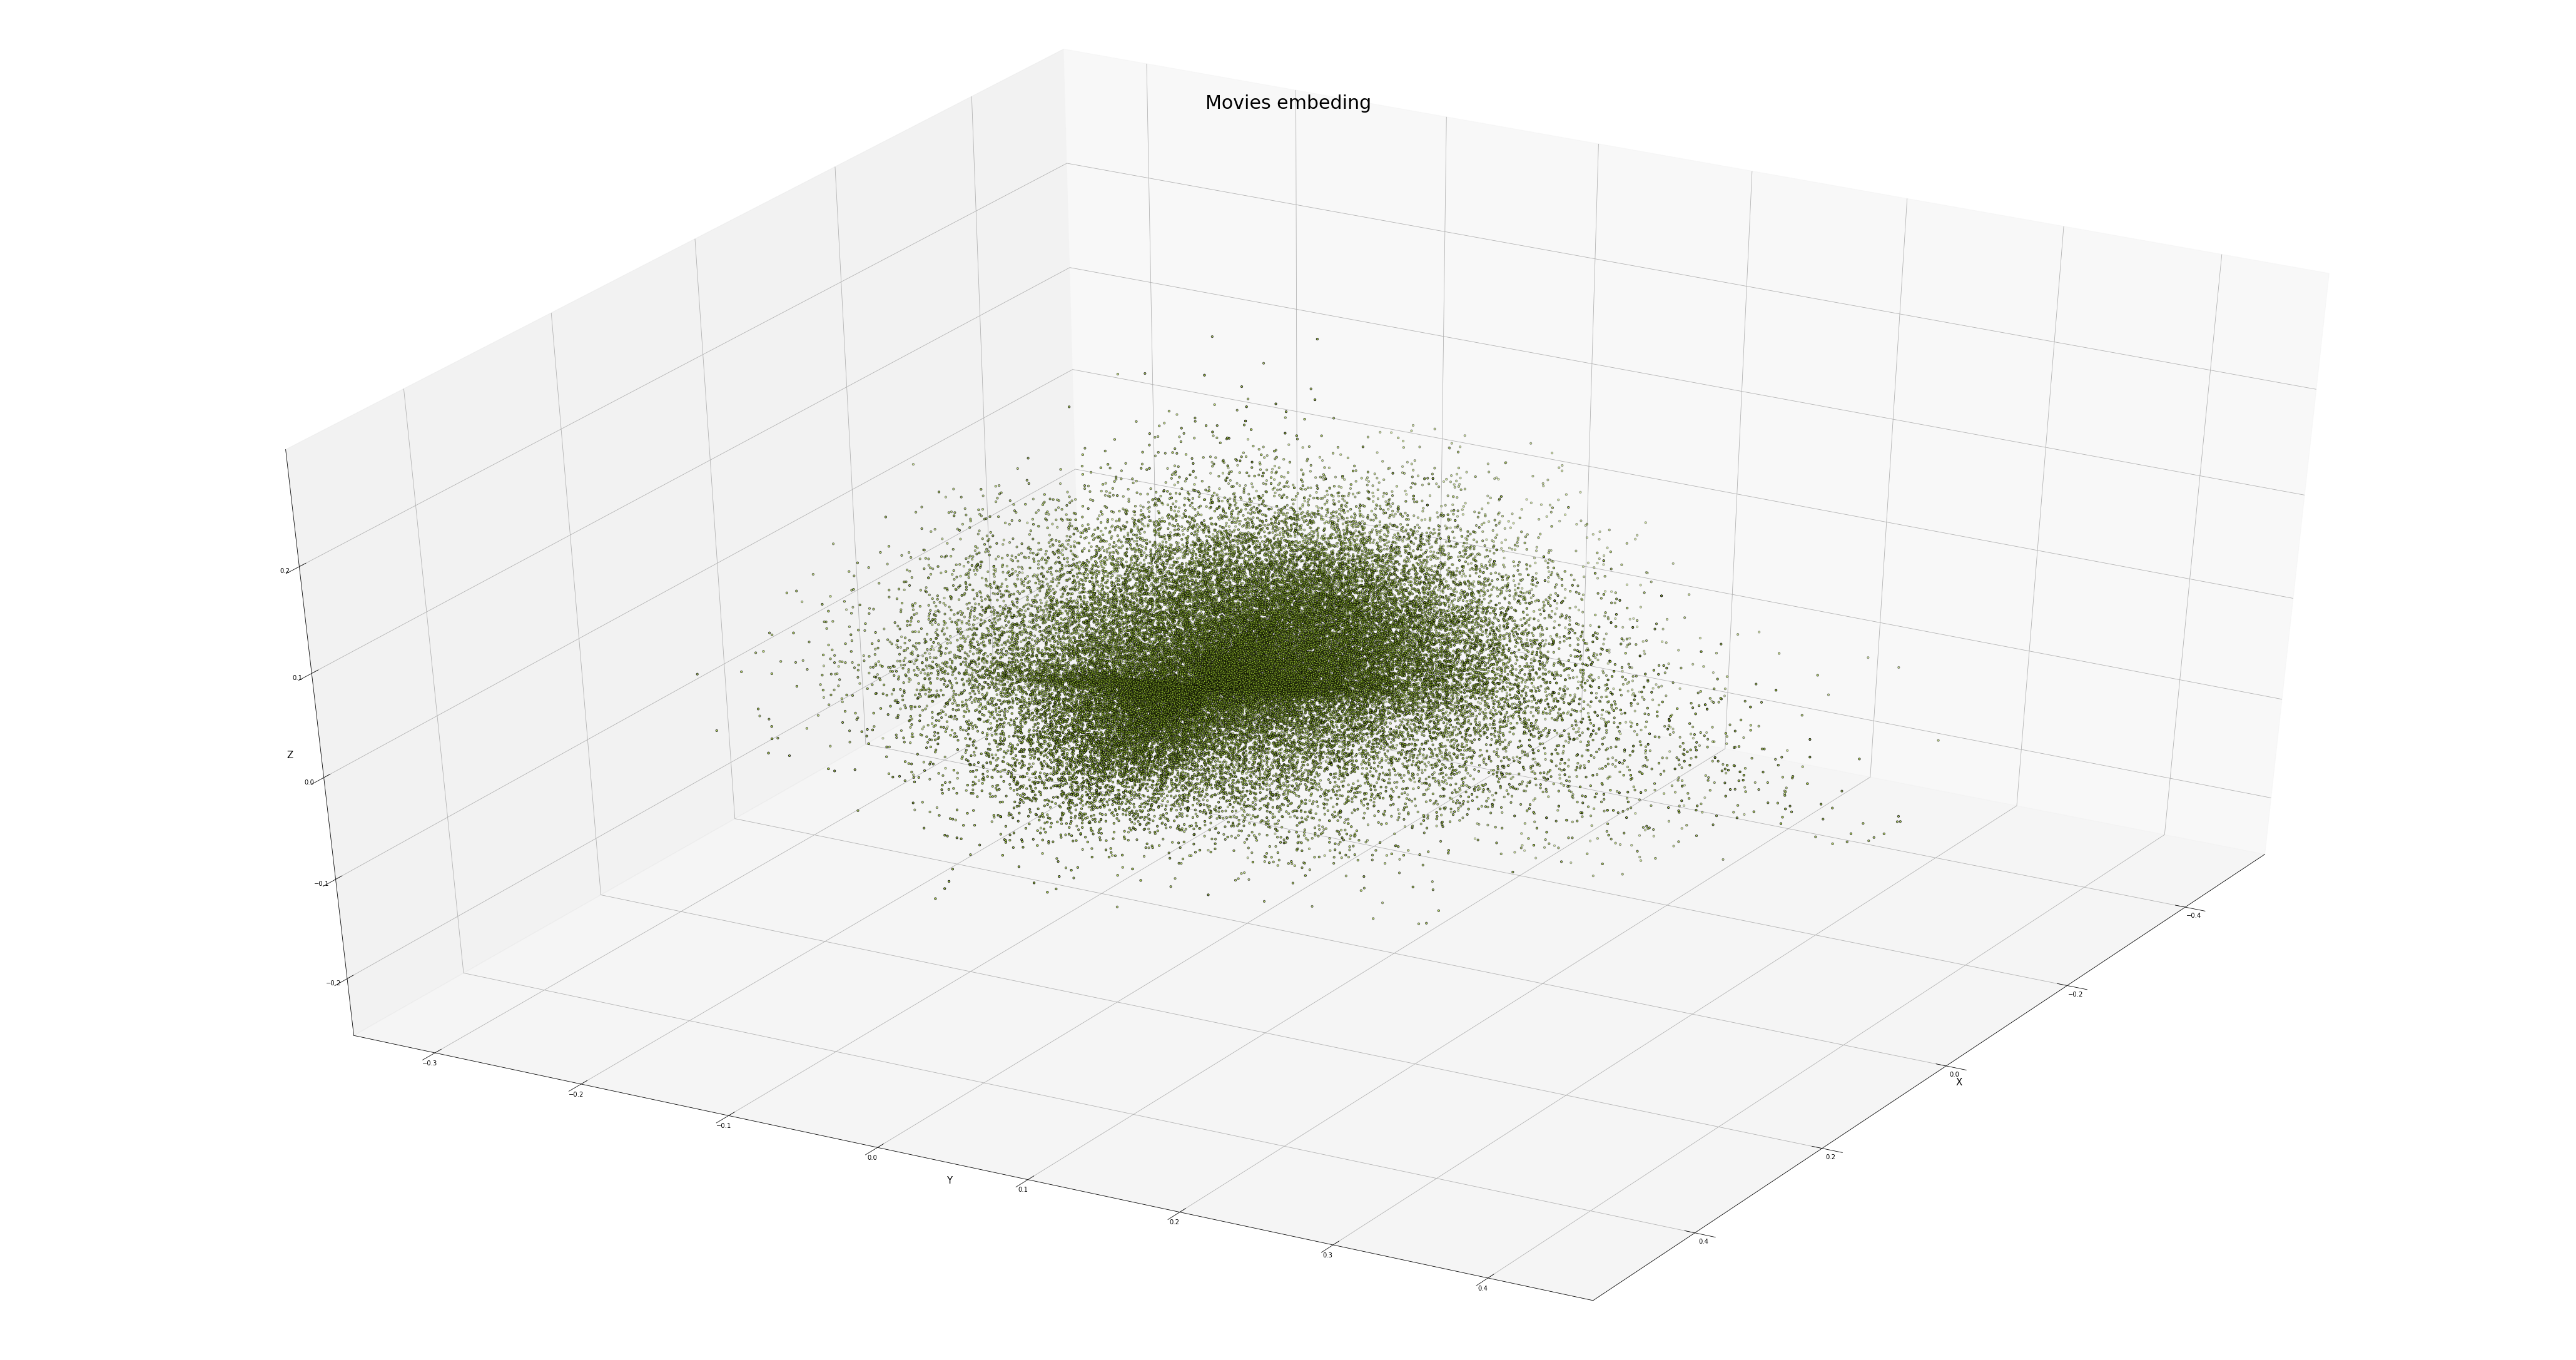

In [64]:
PCAPlotter() \
    .data(movies_pca) \
    .canvas(size=(60, 30), elevation=40, azimuthal_angle=30) \
    .title('Movies embeding', font_size = 30) \
    .point(radius=10) \
    .plot()

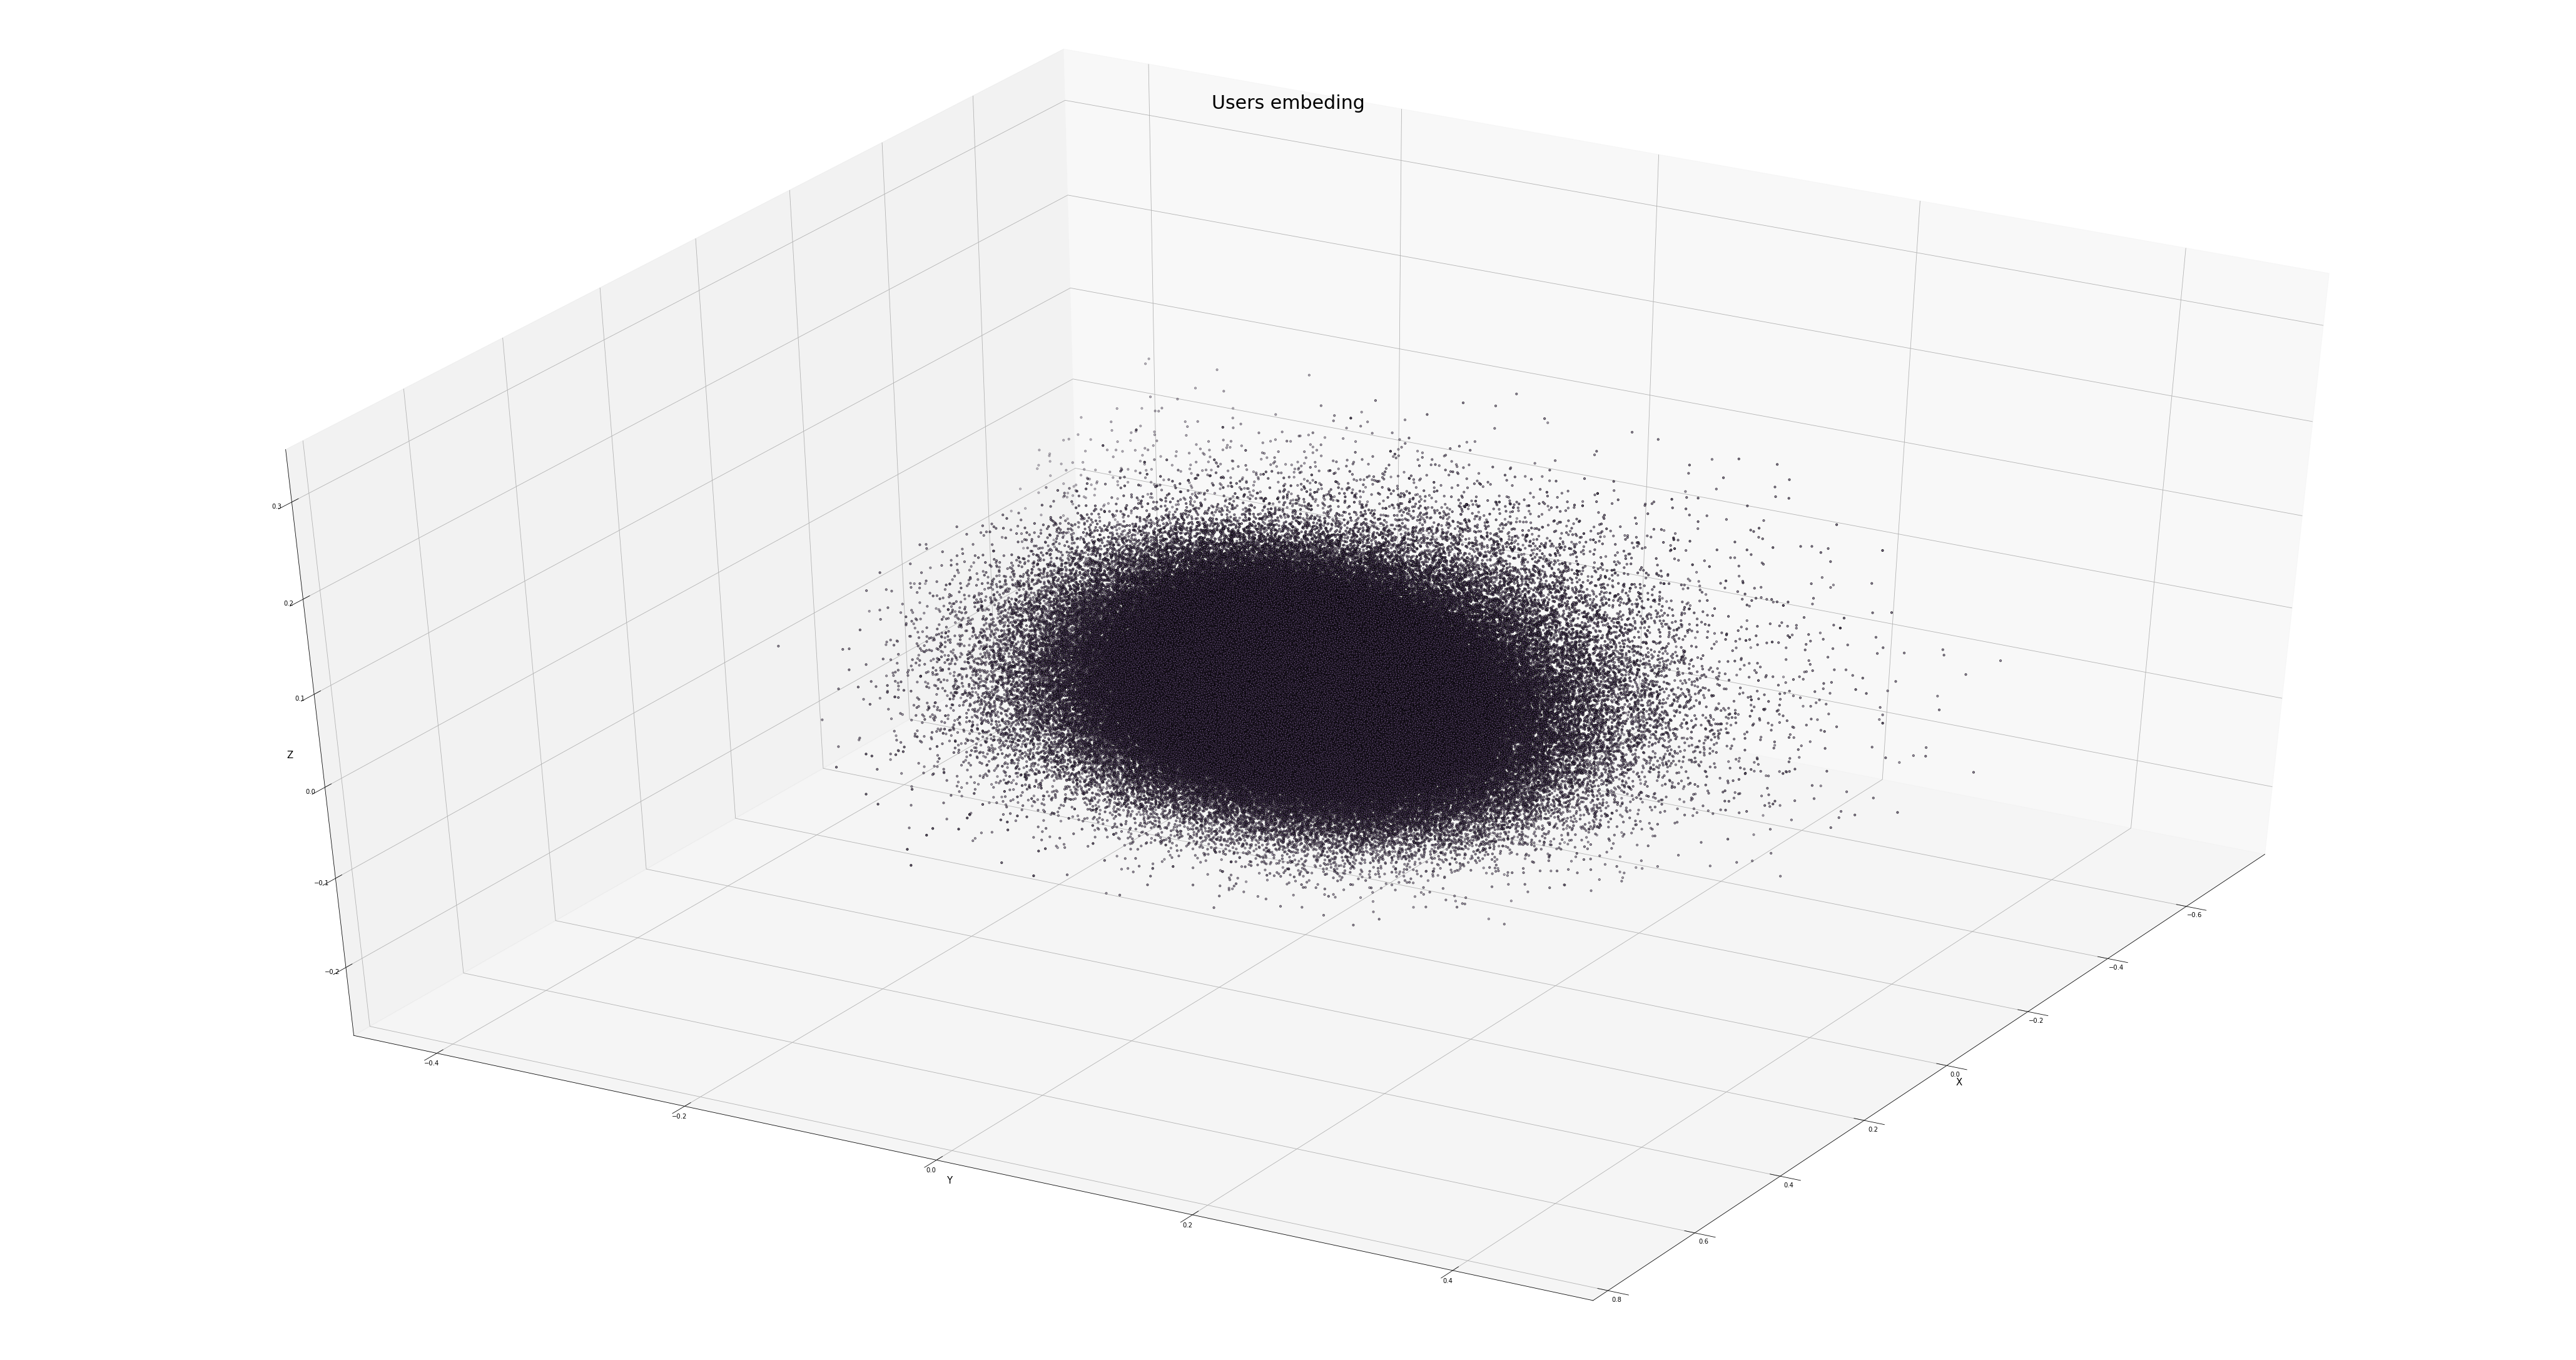

In [65]:
PCAPlotter() \
    .data(users_pca) \
    .canvas(size=(60, 30), elevation=40, azimuthal_angle=30) \
    .title('Users embeding', font_size = 30) \
    .point(radius=10) \
    .plot()

In [66]:
ratings = dataset.ratings()
movies = dataset.movies()

In [68]:
import pandas as pd

features = pd.merge(ratings, movies, how='left', on='movieId')
features = features[['userId', 'movieId', 'user', 'movie', 'genres']]

features['genres'] = features['genres'].apply(lambda)

features.head()

userId  movieId  user  movie          genres
0       1      307     0    304           Drama
1       1      481     0    477  Drama|Thriller
2       1     1091     0   1069          Comedy
3       1     1257     0   1229  Comedy|Romance
4       1     1449     0   1414          Comedy